In [36]:
#%matplotlib inline
import ROOT
ROOT.gSystem.Load("/mnt/c/Users/marratia/Linux/RooUnfold/libRooUnfold")
from ROOT import gRandom, TH1, TH1D, TH2D, cout, THStack
#for unfolding
from ROOT import RooUnfoldResponse
from ROOT import RooUnfold
from ROOT import RooUnfoldBayes
from ROOT import RooUnfoldSvd
from ROOT import RooUnfoldTUnfold
from ROOT import RooUnfoldBinByBin
from ROOT import RooUnfoldIds

#plotting, style
from matplotlib import pyplot as plt
ROOT.gStyle.SetOptStat('')
from AtlasCommonUtils import SetAtlasStyle
from Legend import Legend
from ROOT import TLatex
SetAtlasStyle()
ROOT.gStyle.SetPalette(ROOT.kViridis);
ROOT.gStyle.SetTitleYOffset(0.85)
ROOT.gStyle.SetEndErrorSize(10)

### Get Data and MC files

In [37]:
jet_R = '0.4'
jet_ptmin = '10.0'
clus_ptmin = '20.0'

datatype = 'pPb'
path = '/mnt/c/Users/marratia/Linux/PionHadronCorr/NtupleAnalysis/'
#datatype = 'pPb'
if(datatype=='pp'): 
    Datafile = ROOT.TFile('%sOut_Skimmed_17q_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,clus_ptmin, jet_R,jet_ptmin),'READ')
    tag = "5 TeV pp data"
    GammaJet_MC    = ROOT.TFile('%sOut_Skimmed_18b10a_pthat1to6_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,clus_ptmin, jet_R,jet_ptmin),'READ')

elif(datatype=='pPb'):
    Datafile = ROOT.TFile('%sOut_Skimmed_13def_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,clus_ptmin, jet_R,jet_ptmin),'READ')
    tag = "5 TeV p-Pb data"
    GammaJet_MC    = ROOT.TFile('%sOut_17g6a1_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,clus_ptmin, jet_R,jet_ptmin),'READ')

Dijet_MC = ROOT.TFile('%sOut_18g7a_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,clus_ptmin, jet_R,jet_ptmin),'READ')




In [38]:
matrixname = {}
matrix_axesname = {}
axestitle = {}
histoname = {}

matrixname['jetpt'] = 'h_jetpt_Matrix'
matrix_axesname['jetpt'] = '; jet p^{reco}_{T} [GeV/c] ; jet p_{T}^{true} [GeV/c] '
axestitle['jetpt'] = '; jet p_{T} [GeV/c]; normalized counts'
histoname['jetpt'] = 'jetpt_subtracted'


matrixname['Xj'] = 'h_Xj_Matrix'
matrix_axesname['Xj'] = '; X_{j}^{reco} ; X_{j}^{true} '
axestitle['Xj'] = '; X_{j} ; normalized counts'
histoname['Xj'] = 'Xj_subtracted'

matrixname['Xobs'] = 'h_XobsPb_Matrix'
matrix_axesname['Xobs'] = '; X_{obs}^{reco} ; X_{obs}^{true} '
axestitle['Xobs'] = '; X_{pbs} ; normalized counts'
histoname['Xobs'] = 'XpbsPb_subtracted'

variable = 'jetpt'

if 'pp' in datatype:
    datatitle = '5 TeV pp'
else: 
    datatitle = '5 TeV p-Pb'

### Get response Matrix and plot it, also true/reco ratio

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file UnfoldingMatrixpPb.pdf has been created


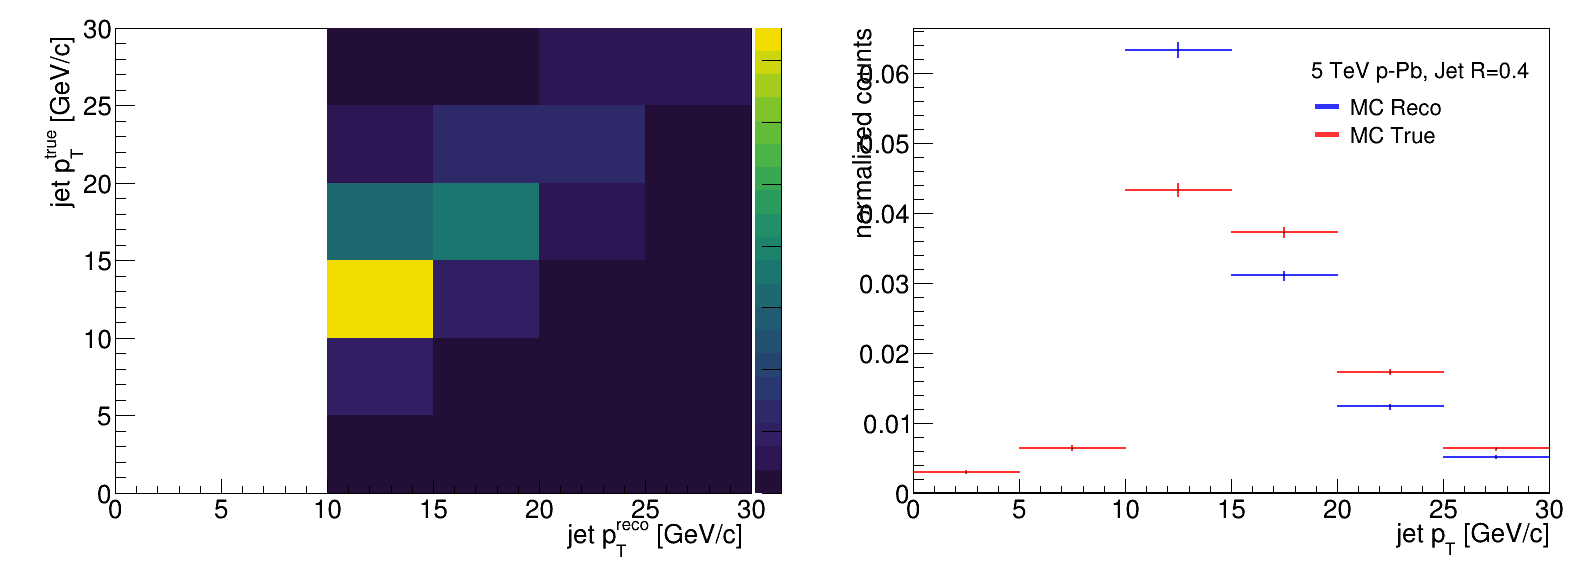

In [39]:
responseMatrix = GammaJet_MC.Get(matrixname[variable]);
#responseMatrix = MCfile.Get('h_jetpt_Matrix_gluon')

#responseMatrix.Scale(0.5)
#responseMatrix.Scale(1/responseMatrix.GetXaxis().GetBinWidth(1))

#responseMatrix.SetAxisRange(10,30, "X")


#responseMatrix.ClearUnderflowAndOverflow()
mc_reco = responseMatrix.ProjectionX()
mc_truth = responseMatrix.ProjectionY()
mc_truth.SetLineColorAlpha(2,0.8)
mc_reco.SetLineColorAlpha(4,0.8)

##draw mc truth, mc reco, response matrix
c = ROOT.TCanvas('c','c',1600,600)
c.Divide(2)
c.cd(1)
responseMatrix.Draw('colz')
responseMatrix.SetTitle(matrix_axesname[variable])

#ROOT.gPad.SetLogz()
c.cd(2)


label = Legend("%s, Jet R=%s"%(datatitle,jet_R))
label.Add(mc_reco,'MC Reco','L')
label.Add(mc_truth,'MC True','L')

hs_mc = ROOT.THStack()
hs_mc.Add(mc_reco)
hs_mc.Add(mc_truth)
hs_mc.Draw('nostack')
hs_mc.SetTitle(axestitle[variable])

label.Draw(0.65,.87)
#c.cd(3)
#ratio_mc = mc_truth.Clone()
#ratio_mc.SetMinimum(0)
#ratio_mc.SetLineColor(1)
#ratio_mc.Divide(mc_reco)
#atio_mc.Draw()
#ratio_mc.SetTitle(' ; x^{truth}; Truth/Reco')
c.Draw()
c.SaveAs('UnfoldingMatrix%s.pdf'%(datatype))



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file KinematicEfficiencypPb.pdf has been created


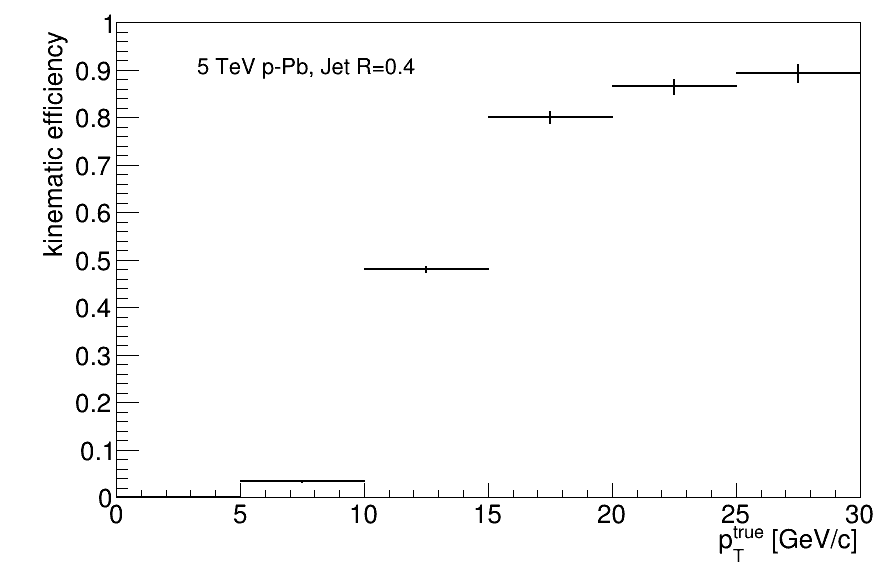

In [40]:
jetefficiency = GammaJet_MC.Get("jetefficiency")
c = ROOT.TCanvas('c','c',900,600)
jetefficiency.Draw()
jetefficiency.SetMaximum(1.0)
jetefficiency.SetTitle("; p_{T}^{true} [GeV/c]; kinematic efficiency")


label = Legend("%s, Jet R=%s"%(datatitle,jet_R))
label.Draw(0.22,.87)

c.Draw()

c.SaveAs('KinematicEfficiency%s.pdf'%(datatype))


### DEFINE DATA FOR UNFOLDING 

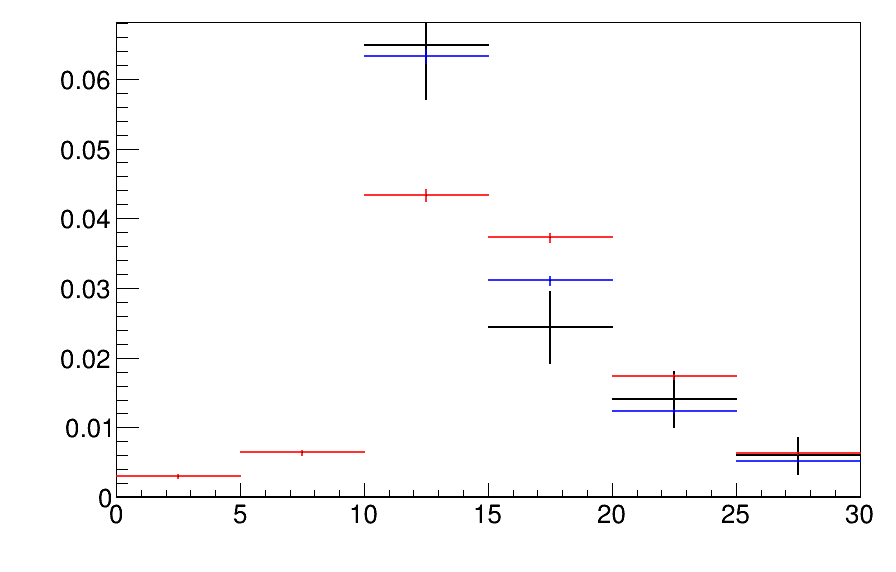

In [41]:
#datafile_subtracted = ROOT.TFile('%sfinalplots_jetptOut_Skimmed_17q_ptmin12.0_Nevent_830735_clus15.0_max30.0_JETPT_10.0_.root'%path,'READ')
if(datatype=='pp'):
    datafile_subtracted = ROOT.TFile('%sfinalplots_%sOut_Skimmed_17q_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,variable,clus_ptmin, jet_R,jet_ptmin),'READ')
else:
    datafile_subtracted = ROOT.TFile('%sfinalplots_%sOut_Skimmed_13def_Lambda_clus%s_max30.0_JET_R%s_PT_%s_Iso1.5.root'%(path,variable,clus_ptmin,jet_R,jet_ptmin),'READ')
#datafile_subtracted = ROOT.TFile('%sOut_18b10a_clus15.0_max30.0_JETPT_10.0_Iso1.5_EVEN.root'%path,'READ')

data_inputforunfolding = datafile_subtracted.Get(histoname[variable])
#data_inputforunfolding = datafile_subtracted.Get('hSR_jetpt')
data                   = data_inputforunfolding.Clone()
#data_bkgsub.Clone()
#data_inputforunfolding = data.Clone()

c.Clear()
hs = ROOT.THStack()
hs.Add(data_inputforunfolding)
hs.Add(mc_reco)
hs.Add(mc_truth)
hs.Draw("nostack")
#data_inputforunfolding .Draw()
#mc_reco.Draw("histsame")
#mc_truth.Draw("histsame")
c.Draw()

### UNFOLDING 

In [42]:
response= RooUnfoldResponse(mc_reco, mc_truth, responseMatrix,"response","response")
response.UseOverflow()

data_unfolded = {}
ErrorMatrices = {}
unfold = {}

nbayes_iter = 4
unfold['Bayes'] =  RooUnfoldBayes(response, data_inputforunfolding, nbayes_iter)
unfold['Bayes'].IncludeSystematics()


data_unfolded['Bayes'] = unfold['Bayes'].Hreco();
ErrorMatrices['Bayes'] = unfold['Bayes'].Ereco();


SVD_k = 3
unfold['SVD'] = RooUnfoldSvd(response, data_inputforunfolding, SVD_k)
data_unfolded['SVD'] = unfold['SVD'].Hreco();
ErrorMatrices['SVD'] = unfold['SVD'].Ereco();


data_unfolded['SVD_next'] = RooUnfoldSvd(response, data_inputforunfolding, SVD_k+1).Hreco();
data_unfolded['SVD_next2'] = RooUnfoldSvd(response, data_inputforunfolding, SVD_k+2).Hreco();


data_unfolded['binbybin'] = RooUnfoldBinByBin(response, data_inputforunfolding).Hreco();


IDS_iter = 5
unfold['IDS'] = RooUnfoldIds(response, data_inputforunfolding, IDS_iter)
data_unfolded['IDS'] = unfold['IDS'].Hreco();
ErrorMatrices['IDS'] = unfold['IDS'].Ereco();


#print data_unfolded

Now unfolding...
Iteration : 0
Chi^2 of change 1.09828e-05
Iteration : 1
Chi^2 of change 7.18008e-06
Iteration : 2
Chi^2 of change 4.78207e-06
Iteration : 3
Chi^2 of change 3.21466e-06
Calculating covariances due to number of measured events
Calculating covariance due to unfolding matrix...
SVD init 8 x 8 bins, kreg=3
SVD init 8 x 8 bins, kreg=4
SVD init 8 x 8 bins, kreg=5
IDS init 8 x 8


Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.274429
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 4
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 1.360540
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 5
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 4.049888


In [43]:
for key in ['Bayes','SVD','IDS']:
    print '%%%%%%%%%%%%%%%%%%%%%% ', key
    print unfold[key].Chi2(mc_truth,0)
    print 'Option 1: use errors propagated through the unfolding'
    print unfold[key].Chi2(mc_truth,1)
    print 'Option 2: use covariance matrix returned from unfolding'
    print unfold[key].Chi2(mc_truth,2)
    print 'Option 3: use covariance matrix from the variation of the results in toy MC tests'
    print unfold[key].Chi2(mc_truth,3)

%%%%%%%%%%%%%%%%%%%%%%  Bayes
0.00510163942484
Option 1: use errors propagated through the unfolding
4.85937118493
Option 2: use covariance matrix returned from unfolding
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
3.29432103272
Option 3: use covariance matrix from the variation of the results in toy MC tests
Now unfolding...
Iteration : 0
Chi^2 of change 3.01892e-05
Iteration : 1
Chi^2 of change 2.00948e-05
Iteration : 2
Chi^2 of change 1.32237e-05
Iteration : 3
Chi^2 of change 8.72542e-06
Now unfolding...
Iteration : 0
Chi^2 of change 5.22546e-06
Iteration : 1
Chi^2 of change 3.98464e-06
Iteration : 2
Chi^2 of change 3.23076e-06
Iteration : 3
Chi^2 of change 2.68609e-06
Now unfolding...
Iteration : 0
Chi^2 of change 6.73875e-06
Iteration : 1
Chi^2 of change 3.74475e-06
Iteration : 2
Chi^2 of change 2.21164e-06
Iteration : 3
Chi^2 of change 1.35852e-06
Now unfolding...
Iteration : 0
Chi^2 of change 2.42751e-05
Itera

Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.929707
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 1.087244
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 3
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.180368
Warning in <TH2D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH2D::Sumw2>: Sum of squares of we

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file ErrorCorrelationspPb.pdf has been created


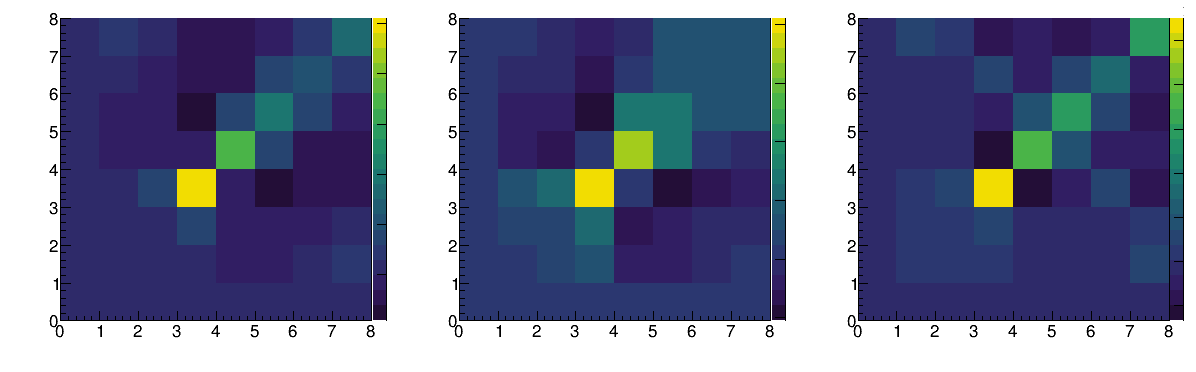

In [44]:
c = ROOT.TCanvas('c','c',1200,400)

c.Divide(3)
c.cd(1)
#print ErrorMatrices.GetMaximum()
ErrorMatrices['Bayes'].Draw("colz")
#ErrorMatrices['Bayes'].GetXaxis().SetTitle('; bin reco bin truth')
c.cd(2)
ErrorMatrices['SVD'].Draw("colz")
c.cd(3)
ErrorMatrices['IDS'].Draw("colz")
c.SaveAs('ErrorCorrelations%s.pdf'%(datatype))

c.Draw()



In [45]:
def GetCorrelationMatrix ( cov, name):

    nrows= cov.GetNrows()
    ncolumns = cov.GetNcols()
    
    h= ROOT.TH2D (name, "", nrows, 0, nrows, ncolumns, 0, ncolumns);
    h.SetAxisRange (-1.0, 1.0, "Z")
    for i in range(nrows) :
        for j in range(ncolumns) :
            Viijj= cov(i,i)*cov(j,j)
            if Viijj>0.0: h.SetBinContent (i+1, j+1, cov(i,j)/ROOT.TMath.Sqrt(Viijj))
            
    return h


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file PearsonpPb.pdf has been created


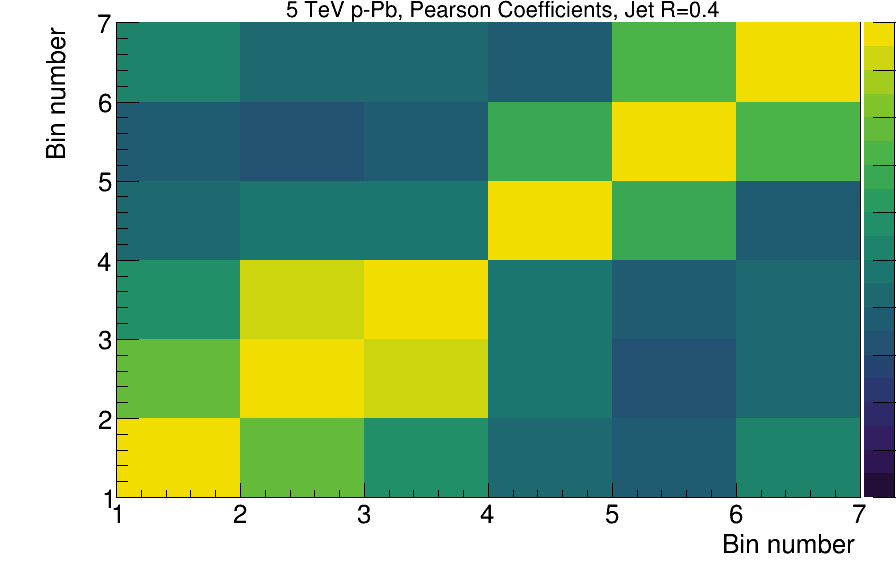

In [46]:
c = ROOT.TCanvas('c','c',900,600)
correlation = {}

correlation['Bayes'] = GetCorrelationMatrix(ErrorMatrices['Bayes'], 'Bayes')
correlation['Bayes'].Draw('colz')
correlation['Bayes'].GetXaxis().SetRangeUser(1,7)
correlation['Bayes'].GetYaxis().SetRangeUser(1,7)
correlation['Bayes'].GetXaxis().SetTitle('Bin number')
correlation['Bayes'].GetYaxis().SetTitle('Bin number')
correlation['Bayes'].SetTitle('Bin number')

label = Legend("%s, Pearson Coefficients, Jet R=%s"%(datatitle,jet_R))
label.Draw(0.32,.97)


c.Draw()
c.SaveAs('Pearson%s.pdf'%(datatype))


Error: Unknown legend option
Bayes   3   12.5  0.045  0.007
Bayes   4   17.5  0.029  0.006
Bayes   5   22.5  0.017  0.005
Bayes   6   27.5  0.009  0.003
SVD   3   12.5  0.044  0.006
SVD   4   17.5  0.029  0.006
SVD   5   22.5  0.016  0.004
SVD   6   27.5  0.008  0.002
IDS   3   12.5  0.046  0.007
IDS   4   17.5  0.026  0.006
IDS   5   22.5  0.018  0.005
IDS   6   27.5  0.008  0.004


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file UnfoldedresultpPb.pdf has been created


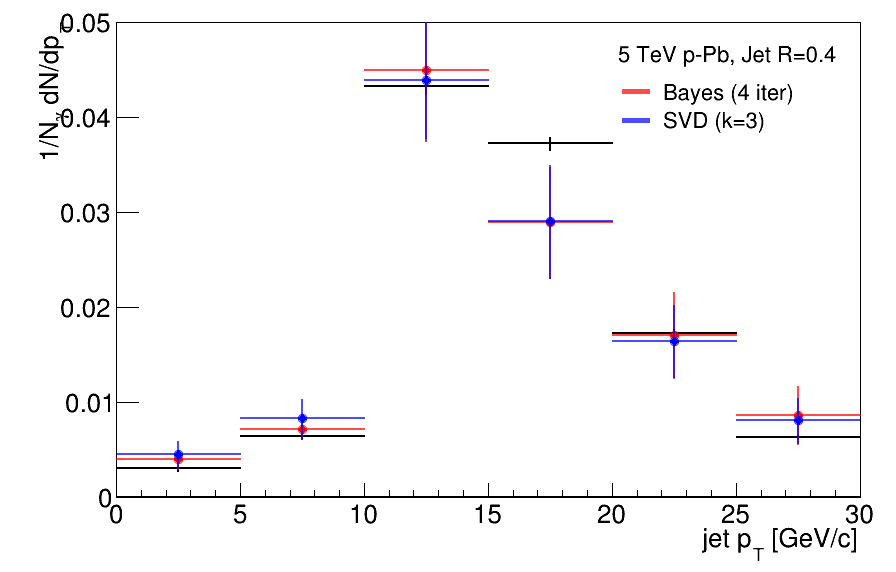

In [47]:
c = ROOT.TCanvas('c','c',900,600)

label = Legend("%s, Jet R=%s"%(datatitle,jet_R))
alpha = 0.7
hstack = ROOT.THStack()
data.SetLineWidth(2)
data.SetLineColorAlpha(1,alpha)

mc_truth.SetLineColor(1)
mc_truth.SetMarkerColor(1)
hstack.Add(mc_truth,'l')
label.Add(data,'MC truth','hist')

data.SetMarkerStyle(20)

color = {}
color['SVD'] = 4
color['Bayes'] = 2
color['SVD_next'] = ROOT.kOrange
color['SVD_next2'] = ROOT.kOrange+4

color['binbybin'] = 1
color['IDS'] = ROOT.kGreen+3

#data_unfolded['Bayes'].SetMarkerColorAlpha(4,0)


#data_unfolded['IDS'].SetLineColor(ROOT.kCyan) 

for key in ['Bayes','SVD','IDS']:
    data_unfolded[key].SetMarkerStyle(20)
    data_unfolded[key].SetLineWidth(2)
    data_unfolded[key].SetLineColorAlpha(color[key],alpha)
    data_unfolded[key].SetMarkerColor(color[key])
    for i in range(3,data_unfolded[key].GetNbinsX()+1):
        print key, ' ' , i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_unfolded[key].GetBinContent(i), ' %2.3f'%data_unfolded[key].GetBinError(i)

hstack.Add(data_unfolded['Bayes'])
hstack.Add(data_unfolded['SVD'])
#hstack.Add(data_unfolded['IDS'] )

#hstack.Add(data_unfolded['SVD_next'])
#hstack.Add(data_unfolded['SVD_next2'])


label.Add(data_unfolded['Bayes'],'Bayes (%i iter)'%nbayes_iter,'L')      
label.Add(data_unfolded['SVD'], 'SVD (k=%i)'%SVD_k,'L')
#label.Add(data_unfolded['SVD_next'], 'Data Unfolded (SVD,k=%i)'%(SVD_k+1),'L')
#label.Add(data_unfolded['IDS'], 'IDS (%i iter)'%IDS_iter,'L')


hstack.SetTitle('; jet p_{T} [GeV/c]; 1/N_{#gamma} dN/dp_{T}')
hstack.Draw('nostack')
hstack.GetYaxis().SetNdivisions(6)
hstack.SetMaximum(0.05)
#ROOT.gPad.SetLogy()
label.Draw(.69,.89)

c.Draw()
c.SaveAs('Unfoldedresult%s.pdf'%(datatype))

#Correcting for efficiency


In [48]:
##EFFICIENCY CORRECTION

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file RefoldingCheck_pPb.pdf has been created


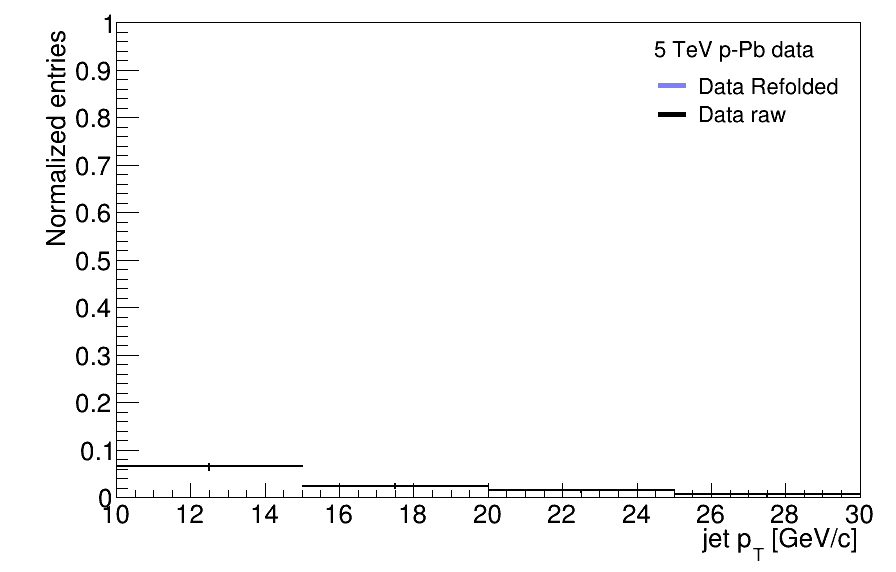

In [49]:
##refolding the distribution:
c = ROOT.TCanvas('c','c',900,600)

key = 'SVD'

N = data_unfolded[key].GetNbinsX()


data_refolded= data_unfolded[key].Clone()
data_refolded.SetLineColorAlpha(4,0.5)

for ireco in range(0,N+1):
    temp = 0
    for itruth in range(0,N+1):
        #print responseMatrix.GetBinContent(itruth,ireco)
        #print data_unfolded['SVD'].GetBinContent(itruth)
        temp += responseMatrix.GetBinContent(ireco,itruth)*data_unfolded[key].GetBinContent(itruth)
    data_refolded.SetBinContent(ireco, temp)
    
    
c.Clear()
data_inputforunfolding.GetXaxis().SetRangeUser(10,30)
data_inputforunfolding.GetXaxis().SetTitle(' jet p_{T} [GeV/c]')
data_inputforunfolding.GetYaxis().SetTitle(' Normalized entries')

data_inputforunfolding.Draw()
data_inputforunfolding.SetMaximum(1)
#data_refolded.DrawNormalized('histsame')

#data_unfolded[key].SetLineStyle(ROOT.kDashed)

#data_unfolded[key].DrawNormalized('histsame')
#data_unfolded['SVD_next'].DrawNormalized('histsame')



label = Legend(tag)
#label.Add(data_unfolded[key], '%s'%key,'L')
label.Add(data_refolded, 'Data Refolded ','L')
label.Add(data_inputforunfolding, 'Data raw ','L')
label.Draw(.73,.9)


c.Draw()
c.SaveAs('RefoldingCheck_%s.pdf'%(datatype))

In [50]:
def SetHistoStyle(h,color=2,alpha=0.5):
    h.SetMarkerColor(color)
    h.SetLineColor(color)
    h.SetMarkerStyle(20)
    h.SetMarkerSize(1)

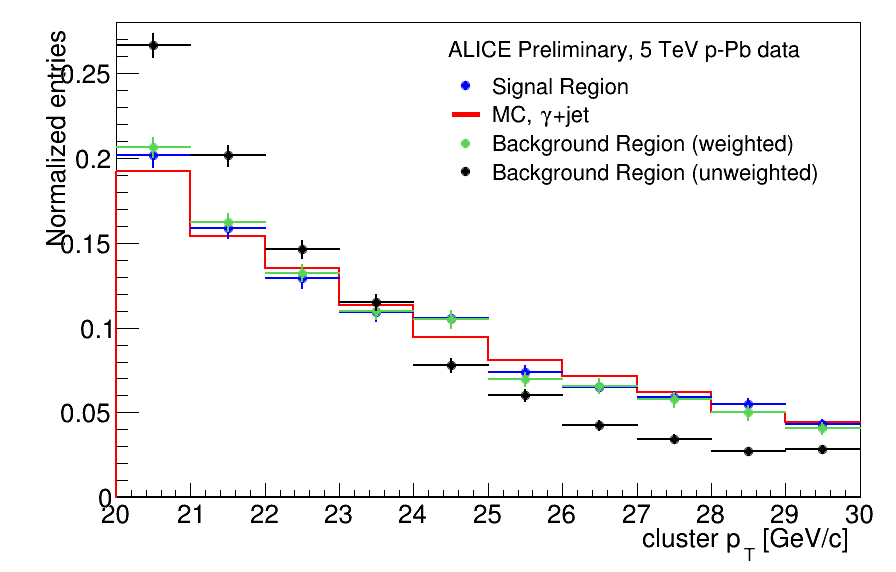

In [51]:
c.Clear()
hMC_clusterpt = GammaJet_MC.Get('hSR_clusterpt')
hSR_clusterpt  =  Datafile.Get('hSR_clusterpt')
hBR_clusterpt  =  Datafile.Get('hBR_clusterpt')
hBR_clusterpt_unweighted  =  Datafile.Get('hBR_clusterpt_unweighted')
hNonIso_clusterpt  =  Dijet_MC.Get('hNonIso_clusterpt')


SetHistoStyle(hMC_clusterpt,2)
SetHistoStyle(hSR_clusterpt,4)
SetHistoStyle(hBR_clusterpt,8)
SetHistoStyle(hBR_clusterpt_unweighted,1)
SetHistoStyle(hNonIso_clusterpt , 9)


hMC_clusterpt.Scale(1.0/hMC_clusterpt.Integral())
hSR_clusterpt.Scale(1.0/hSR_clusterpt.Integral())
hBR_clusterpt.Scale(1.0/hBR_clusterpt.Integral())
hBR_clusterpt_unweighted.Scale(1.0/hBR_clusterpt_unweighted.Integral())
hNonIso_clusterpt.Scale(1.0/hNonIso_clusterpt.Integral())

hs = ROOT.THStack()
hs.Add(hMC_clusterpt,"hist")
hs.Add(hSR_clusterpt)
hs.Add(hBR_clusterpt)
hs.Add(hBR_clusterpt_unweighted)
#hs.Add(hNonIso_clusterpt)

label = Legend('ALICE Preliminary, ' +tag)
label.Add(hSR_clusterpt, "Signal Region","P")
label.Add(hMC_clusterpt, "MC, #gamma+jet","L")

label.Add(hBR_clusterpt, 'Background Region (weighted)','P')
label.Add(hBR_clusterpt_unweighted,'Background Region (unweighted)','P')
#label.Add(hNonIso_clusterpt, 'Dijet NonIso')

hs.Draw('nostack')
hs.GetXaxis().SetRangeUser(20.0,30.0)
hs.SetTitle('; cluster p_{T} [GeV/c] ; Normalized entries')
label.Draw(0.50,0.90)


c.Draw()

Bayes
3   12.5  0.045 +/- (stat) 0.007
4   17.5  0.029 +/- (stat) 0.006
5   22.5  0.017 +/- (stat) 0.005
6   27.5  0.009 +/- (stat) 0.003
fully corrected
3   12.5  0.093 +/- (stat) 0.159
4   17.5  0.036 +/- (stat) 0.202
5   22.5  0.020 +/- (stat) 0.265
6   27.5  0.010 +/- (stat) 0.349


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


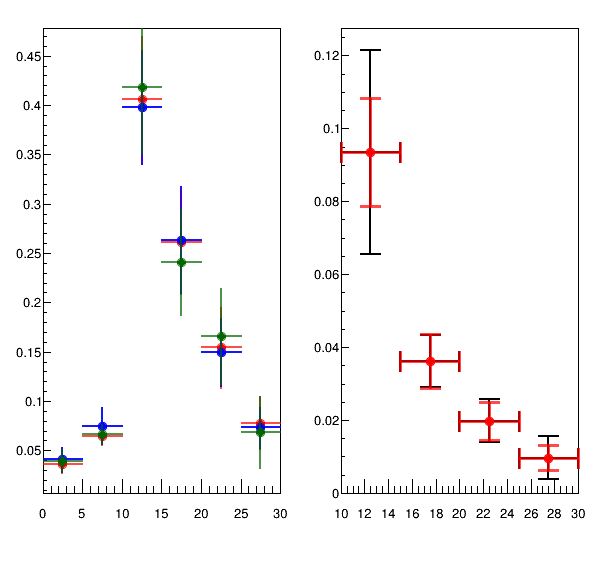

In [52]:
c1 = ROOT.TCanvas('c1','c1',600,600)

c1.Clear()
c1.Divide(2)
c1.cd(1)
data_unfolded['SVD'].DrawNormalized()


#data_binbybin.DrawNormalized("same")
#hSR_Xj_truth.SetFillColorAlpha(2,0.25)
#hSR_Xj_truth.SetLineColorAlpha(2,0.25)
#hSR_Xj_truth.DrawNormalized('histsame')
data_unfolded['Bayes'].DrawNormalized('same')
#data_unfolded['binbybin'].DrawNormalized('same')
data_unfolded['SVD'].DrawNormalized('same')
data_unfolded['IDS'].DrawNormalized('same')


data_fullycorrected = {}
data_systematic  = {}
c1.cd(2)

systematics = [0, 0, 0.30, 0.20, 0.30, 0.60]
for key in ['Bayes']:
    print key
    data_fullycorrected[key] = data_unfolded[key].Clone()
    data_systematic[key] = data_unfolded[key].Clone()
    for i in range(3,data_unfolded[key].GetNbinsX()+1):        print i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_unfolded[key].GetBinContent(i), '+/- (stat) %2.3f'%(data_unfolded[key].GetBinError(i))
    data_fullycorrected[key].Divide(jetefficiency)
    print 'fully corrected'
    for i in range(3,data_fullycorrected[key].GetNbinsX()+1):
        print i , ' ', data_unfolded[key].GetBinCenter(i), ' %2.3f'%data_fullycorrected[key].GetBinContent(i), '+/- (stat) %2.3f'%(data_fullycorrected[key].GetBinError(i)/data_fullycorrected[key].GetBinContent(i))
        data_systematic[key].SetBinContent(i,data_fullycorrected[key].GetBinContent(i))
        
        data_systematic[key].SetBinError(i,data_fullycorrected[key].GetBinContent(i)*systematics[i-1])
        #data_systematic[key].SetBinWidth(i,data_fullycorrected[key].GetBinWidth(i))


data_systematic['Bayes'].SetLineColor(1)
data_systematic['Bayes'].SetFillColor(2)
data_systematic['Bayes'].Draw("E1")

data_fullycorrected['Bayes'].SetLineWidth(3)
data_fullycorrected['Bayes'].Draw("E1same")
data_systematic['Bayes'].GetXaxis().SetRangeUser(10,30)

c1.Draw()